*Author: Pooya Bagheri*               

# 1. Machine Learning (ML) Objective

From now on, our objective is to create statistical learning (or machine learning) models to estimate feeder power loss from voltages at a specific instant. 



# 2. Training and Test Data Sets

The common practice is to randomly split the available data to training and test sets. However, we know our data here is coming from simulations that were generated by random instant load profiles. So, we can go ahead and pick few days of simulation results as Training and another few days for the Test, and it will be automatically a random split. Additionally, the other advantage of keeping time-continuous data is allowing for better visualizations.

Hence, for all the tests of ML models in this project we choose the last 5 of the available 30 days data. For training the linear models here, we grab data of the first 10 days For now we are not loading the whole 25 left days' data to avoid memory limitation problem. Later, we will take advantage of total data through iterative data streaming.
 
Ok, let's create our training and test sets accordingly. Similar to previous [step](Step1-DataExploration.ipynb), we have to use SQL query and also pivoting for the voltage data. In order to avoid repetitive coding, we define a class called *MLinputData* for loading data for generic period of simulation days. (Please refer back to [previous step](Step1-DataExploration.ipynb) for more information, if the below procedure of SQL query and dataframe pivoting of is not clear to your)

Definition of this class is loaded below. Please note that for any future data loading we will rather directly import and use this class.

In [1]:
# %load LoadingDataClass.py
# @author: Pooya Bagheri
import os 
import pandas as pd
from sqlalchemy import create_engine

ResultsDBfile='SimResultsIEEE123NodesCase2.db'

# a class is defined for loading data and covering the SQL and pivoting procedure:
class MLinputData: 
    #initialize the API with the database:
    DB = create_engine('sqlite:///'+os.path.abspath('')+'//'+ResultsDBfile, echo=False)     
    
    def __init__(self,FromDay,ToDay):
        RawVoltages=pd.read_sql_query('''
        select Instants.InstantID,Voltages.NodeID,Voltages.Vmag
        from Instants join Voltages on Instants.InstantID=Voltages.InstantID
        where Instants.Day>=%d and Instants.Day<=%d''' % (FromDay,ToDay),con=self.DB)
        Voltages=RawVoltages.pivot(index='InstantID', columns='NodeID', values='Vmag')
        self.x=Voltages.values
        Ploss=pd.read_sql_query('''
        select Losses.Ploss
        from Instants join Losses on Instants.InstantID=Losses.InstantID
        where Instants.Day>=%d and Instants.Day<=%d''' % (FromDay,ToDay),con=self.DB)
        self.y=Ploss.values        

Now that the class is defined, we can load our train and test data by creating new objects of it:

In [2]:
train=MLinputData(1,5) # Loading Training sets (first 5 days)
test=MLinputData(26,30) # Loading Test sets (last 5 of 30 days)
#Double-checking size of the loaded data sets
print(train.x.shape, train.y.shape, test.x.shape, test.y.shape) 

(7200, 278) (7200, 1) (7200, 278) (7200, 1)


We know that we have one record for each minute and each day has 1440 minutes, so it is coherent to have 7200 records for 5 days. Also, from [previous step](Step1-DataExploration.ipynb), we know that system has 278 nodes, so the width of predictor sets (ie. node voltages) is reasonable as well.

# 3. Classic Linear Regression

We use the linear model module from SKlearn library to train a classic linear regression model:

In [3]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(train.x,train.y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Let's see how the model perfoms on the test data. We also import a metric function from SKlearn library to assess accuracy of estimation on test data using Mean Absolute Error (MAE): 

In [4]:
y_predict=reg.predict(test.x)
from sklearn.metrics import mean_absolute_error
MAE=mean_absolute_error(test.y,y_predict)
print('Average prediction error on test set is %.1f%%' % (MAE/test.y.mean()*100))

Average prediction error on test set is 592656.1%


Wow, it seems that linear regression is completely failing here. Maybe there is a computation difficulty. Let's check the prediction error on the training set:

In [5]:
y_train_predict=reg.predict(train.x)
MAE=mean_absolute_error(train.y,y_train_predict)
print('Average prediction error on training set is %.1f%%' % (MAE/train.y.mean()*100))

Average prediction error on training set is 1.4%


Fortunately, training error seems fine, so there shouldn't be any computation failure. Our model is struggling in generalizing its prediction power to new data. It is actually not very surprising since we already saw the complex and rather nonlinear relationship of voltage and power loss in the [previous step](Step1-DataExploration.ipynb). 

# 4. Linear Models with Feature Engineering

Unfortunately, linear regression has completely failed us so far, but we are not going to simply give up on it. One option we can try to make it work is feature engineering. We want to engineer new features from our raw predictor data. Inspired from the analysis in [previous step](Step1-DataExploration.ipynb), the two features we want to define are mean and std of voltages across system nodes. In that step, we already saw some linear correlation between our output (i.e. power loss) and mean of voltages. We derive new input sets based on these two features and train the linear regression model again:

In [6]:
import numpy as np #importing np for ease of array math operations
def MyFeatureGen(x):
    return np.hstack((x.mean(axis=1).reshape(-1, 1),x.std(axis=1).reshape(-1, 1)))
x_feature_train=MyFeatureGen(train.x)
reg_feature = linear_model.LinearRegression()
reg_feature.fit(x_feature_train,train.y)
x_feature_test=MyFeatureGen(test.x)
y_feature_predict=reg_feature.predict(x_feature_test)
MAE=mean_absolute_error(test.y,y_feature_predict)
print('Average prediction error on test set is %.1f%%' % (MAE/test.y.mean()*100))
y_feature_train_predict=reg_feature.predict(x_feature_train)
MAE=mean_absolute_error(train.y,y_feature_train_predict)
print('Average prediction error on training set is %.1f%%' % (MAE/test.y.mean()*100))

Average prediction error on test set is 19.3%
Average prediction error on training set is 19.0%


Although the prediction error is still high, but it is much better that the disastrous case without any feature engineering. It is interesting to note that training error is however higher than previous case. This is due to very limited flexibility of our model. (Remember it is now only a simple linear regression with two input dimensions!)

Below, we can also look at a plot comparing prediction and actual output for the test set (Please note that in order to avoid repetitive coding, I have coded a module named [MyPlotTools](MyPlotTools.py) in this repository for any future plotting in these analytic notebooks):

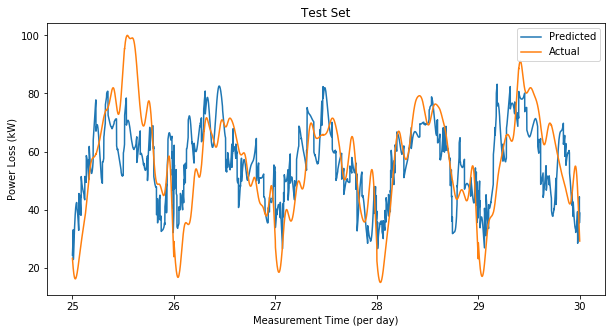

In [8]:
from MyPlotTools import Plot
Plt=Plot(FromDay=26,ToDay=30,plotWidth=10)
Plt.Compare(y_feature_predict,test.y,title='Test Set',legendloc='upper right')

One way to further improve our model is not to limit ourselves to just two features. Our analysis in [previous step](Step1-DataExploration.ipynb) already showed that a dimension reduction method such as Principal Component Analysis (PCA) can gives us variables among which some showed reasonable correlation with the power loss (i.e. output here). Hence, we employ PCA to extract 10 most dominant components from voltages data, and then use these components as the features for the linear regression:

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
x_PCAfeatures_train=pca.fit_transform(train.x)
reg_PCAfeatures = linear_model.LinearRegression()
reg_PCAfeatures.fit(x_PCAfeatures_train,train.y)
x_PCAfeatures_test=pca.transform(test.x)
y_PCAfeatures_predict=reg_PCAfeatures.predict(x_PCAfeatures_test)
MAE=mean_absolute_error(test.y,y_PCAfeatures_predict)
print('Average prediction error on test set is %.1f%%' % (MAE/test.y.mean()*100))
y_PCAfeatures_train_predict=reg_PCAfeatures.predict(x_PCAfeatures_train)
MAE=mean_absolute_error(train.y,y_PCAfeatures_train_predict)
print('Average prediction error on training set is %.1f%%' % (MAE/test.y.mean()*100))

Average prediction error on test set is 4.1%
Average prediction error on training set is 3.9%


Wow, the prediction error has significantly reduced. The main reason is our new model uses 10 feature variables compared to previous case of 2 features. In other words the regression model has now 8 more parameters to play with and can better adjust to represent complex relationships in our data. 

A good way to reward our effort in improving the prediction accuracy is to see the predicted and actual values for the test set in a plot and visually observe the progress so far: 

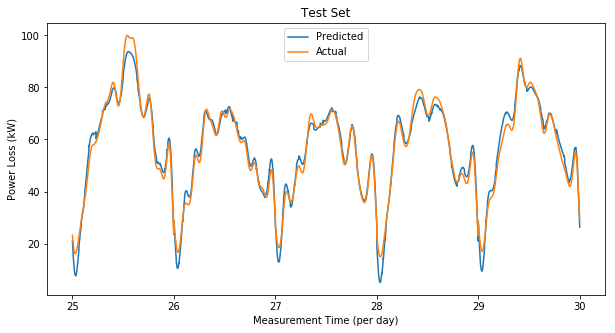

In [12]:
Plt.Compare(y_PCAfeatures_predict,test.y,title='Test Set',legendloc='upper center')

In the [next step](Step3-MLmodels-NeuralNetworks.ipynb), we will try nonlinear ML models such as neural networks on our data.